In [1]:
import torch

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Code for saving Image

In [3]:
# code to save the figures as high-res PNGs
import os
from pathlib import Path
from matplotlib import pyplot as plt

IMAGES_PATH = Path() / "Images/xai_mobilenet_v3_large"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Class to label Mapping

In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_dataloaders(data_dir, batch_size, num_workers=4):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    }

    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    }

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    }
    return dataloaders

data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_dataloaders(data_dir, batch_size)

In [5]:
train_loader = dataloaders['train']
# Get the class to label mapping for training data
train_class_to_idx = train_loader.dataset.class_to_idx
# Print the mapping
print("Class to label mapping:", train_class_to_idx)

Class to label mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## Import Libraries

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Load Saved Model

In [7]:
def load_mobilenet_v3_large(num_classes):
    model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, num_classes)
    return model

# Load your trained model
model = load_mobilenet_v3_large(num_classes=4)
model.load_state_dict(torch.load('Checkpoints_best/mobilenet_v3_large_epoch_5.pth'))
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## Preprocessing the input image

In [8]:
preprocess  = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    img = Image.open(image_path)
    img = preprocess(img).unsqueeze(0)
    return img

## Grad-CAM XAI

In [9]:
# Grad-CAM utility functions
def get_cam(model, img_tensor, target_class=None):
    model.eval()
    
    def forward_hook(module, input, output):
        return output
    
    def backward_hook(module, grad_in, grad_out):
        return grad_out[0]
    
    # Get the final convolution layer from model
    final_conv_layer = model.features
    
    # Register hooks
    forward_output = []
    backward_grad = []
    forward_handle = final_conv_layer.register_forward_hook(
        lambda m, i, o: forward_output.append(o)
    )
    backward_handle = final_conv_layer.register_backward_hook(
        lambda m, i, o: backward_grad.append(o[0])
    )

    # Forward pass
    output = model(img_tensor)
    class_idx = target_class if target_class is not None else torch.argmax(output, dim=1).item()
    
    # Backward pass
    model.zero_grad()
    output[:, class_idx].backward()
    
    # Get the Grad-CAM
    gradients = backward_grad[0].cpu().data.numpy()[0]
    activations = forward_output[0].cpu().data.numpy()[0]
    weights = np.mean(gradients, axis=(1, 2))

    cam = np.zeros(activations.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations[i]
    
    cam = np.maximum(cam, 0)  # ReLU
    cam = cv2.resize(cam, (img_tensor.shape[2], img_tensor.shape[3]))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    forward_handle.remove()
    backward_handle.remove()

    return cam, class_idx

## Plot Grad-CAM Image

In [10]:
def show_cam_on_image(img_path, cam):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the cam to match the image dimensions
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    
    # Normalize and apply colormap to the Grad-CAM
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    # Overlay heatmap on the original image
    cam_img = heatmap + np.float32(img) / 255
    cam_img = cam_img / np.max(cam_img)
    
    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(np.uint8(255 * cam_img))
    plt.axis('off')
    plt.show()

## Single Image Test

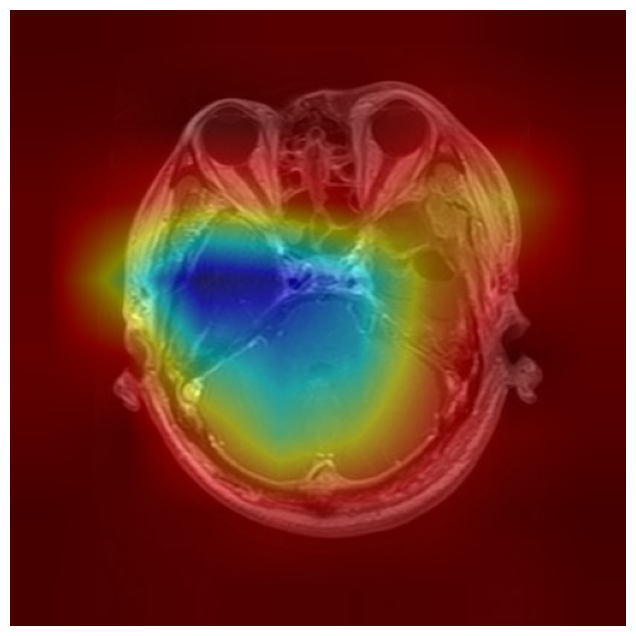

Predicted class: glioma
Actual class: glioma


In [11]:
# Load an example brain tumor image
image_path = 'Dataset/xai_test/glioma-1.jpg'
img_tensor = load_image(image_path)

# Generate Grad-CAM heatmap
cam, predicted_class = get_cam(model, img_tensor)

# Display the heatmap overlayed on the original image
show_cam_on_image(image_path, cam)

# Class to label mapping
class_to_idx = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

# Reverse the dictionary to get label to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

predicted_class = idx_to_class.get(predicted_class, "Unknown Class")
print(f'Predicted class: {predicted_class}')
print(f'Actual class: glioma')

## Test with Multiple Images

In [12]:
# Function to display Grad-CAM heatmaps for multiple images in a row
def show_cam_on_images(image_paths, cams):
    num_images = len(image_paths)
    
    fig, axs = plt.subplots(1, num_images, figsize=(16, 8))
    
    for i, (img_path, cam) in enumerate(zip(image_paths, cams)):
        # Load the original image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize the cam to match the image dimensions
        cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
        
        # Normalize and apply colormap to the Grad-CAM
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        
        # Overlay heatmap on the original image
        cam_img = heatmap + np.float32(img) / 255
        cam_img = cam_img / np.max(cam_img)
        
        # Display each image in its corresponding subplot
        axs[i].imshow(np.uint8(255 * cam_img))
        axs[i].axis('off')
    
    plt.tight_layout()
    save_fig('xai_4_class_4')
    plt.show()

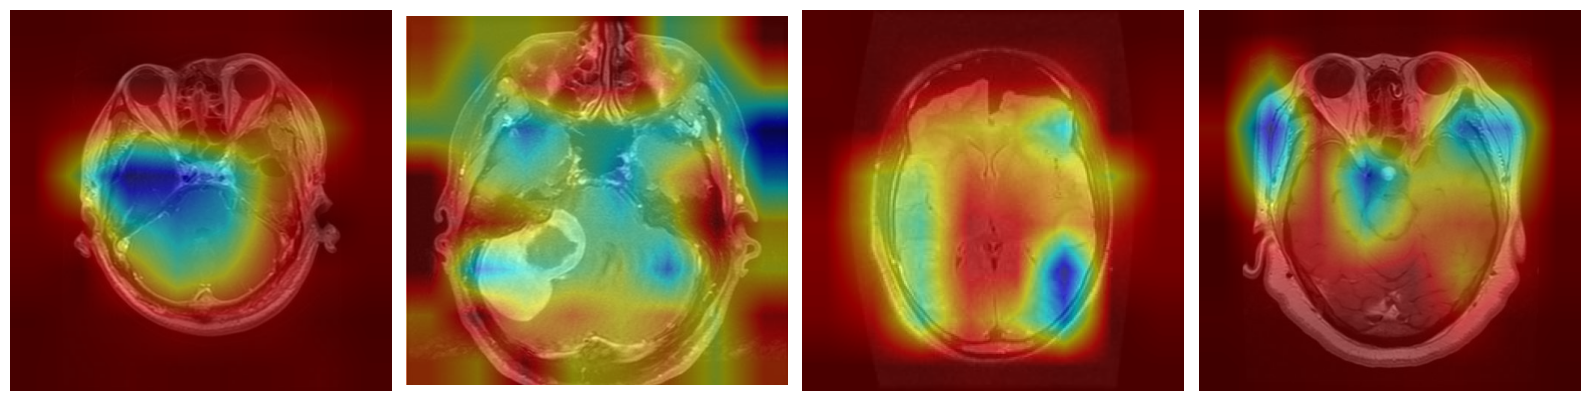

Image: Dataset/xai_test/glioma-1.jpg
Predicted class: glioma
Actual class: glioma-1
---
Image: Dataset/xai_test/meningioma-1.jpg
Predicted class: meningioma
Actual class: meningioma-1
---
Image: Dataset/xai_test/notumor-1.jpg
Predicted class: notumor
Actual class: notumor-1
---
Image: Dataset/xai_test/pituitary-1.jpg
Predicted class: pituitary
Actual class: pituitary-1
---


In [13]:
# List of image paths to test
image_paths = [
    'Dataset/xai_test/glioma-1.jpg',
    'Dataset/xai_test/meningioma-1.jpg',
    'Dataset/xai_test/notumor-1.jpg',
    'Dataset/xai_test/pituitary-1.jpg',
]

# Generate Grad-CAM heatmaps for all images
cams = []
predicted_classes = []

for image_path in image_paths:
    img_tensor = load_image(image_path)
    cam, predicted_class = get_cam(model, img_tensor) 
    cams.append(cam)  # Store the CAM
    predicted_classes.append(predicted_class)

# Display the heatmap overlayed on all images
show_cam_on_images(image_paths, cams)

# Class to label mapping
class_to_idx = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

# Reverse the dictionary to get label to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print predicted classes for each image
for i, predicted_class in enumerate(predicted_classes):
    predicted_label = idx_to_class.get(predicted_class, "Unknown Class")
    actual_label = image_paths[i].split('/')[-1].split('.')[0]
    print(f'Image: {image_paths[i]}')
    print(f'Predicted class: {predicted_label}')
    print(f'Actual class: {actual_label}')
    print('---')

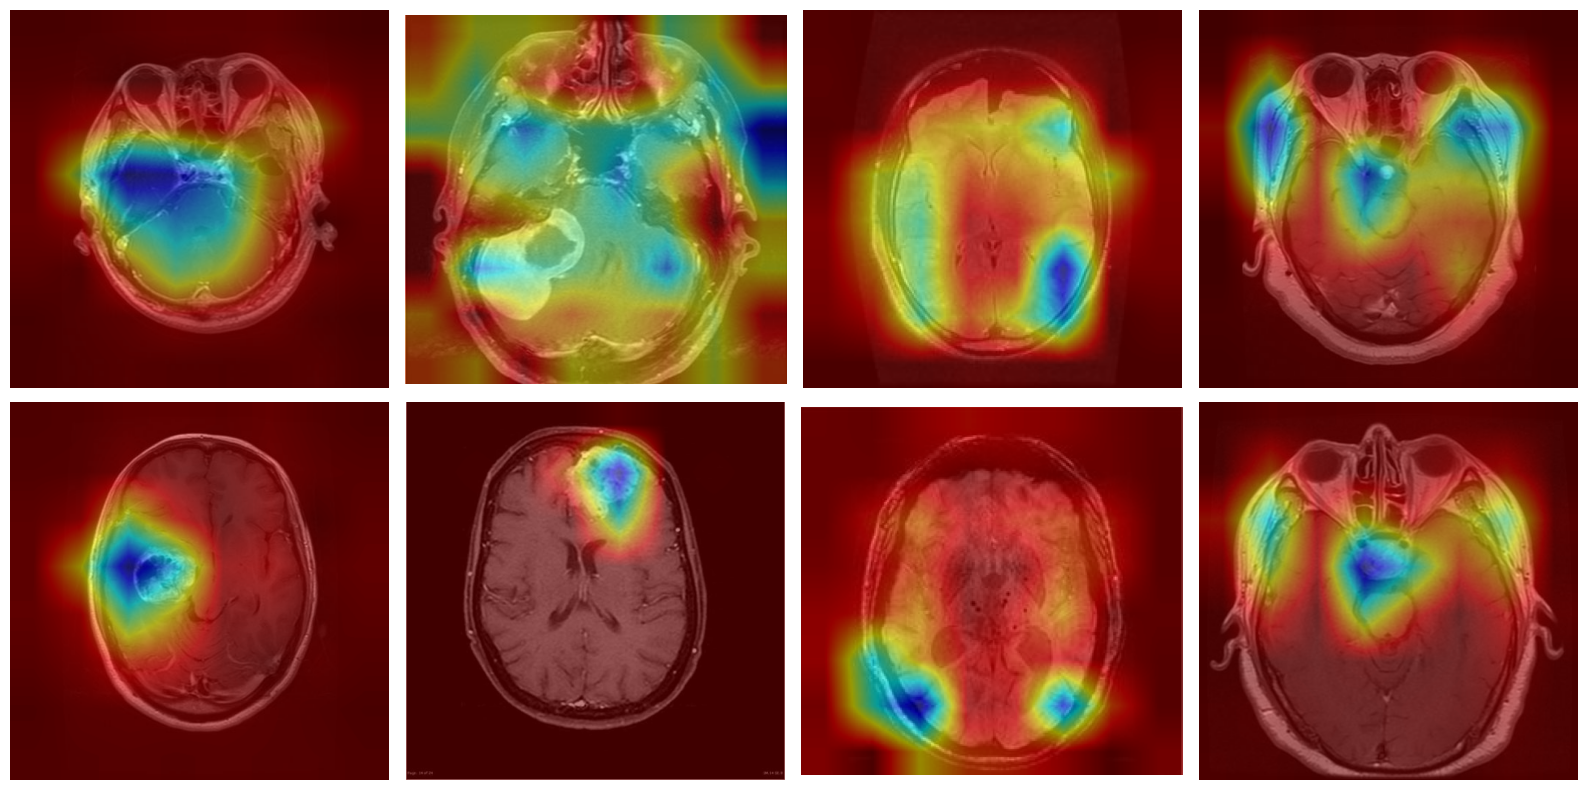

In [14]:
# Function to display Grad-CAM heatmaps for multiple images in 2 rows
def show_cam_on_images(image_paths, cams):
    num_images = len(image_paths)
    num_cols = 4  # 4 image per row
    num_rows = 2  # Number of rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 8))

    for idx, (img_path, cam) in enumerate(zip(image_paths, cams)):
        row = idx // num_cols  # Determine the row index
        col = idx % num_cols   # Determine the column index

        # Load the original image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize the cam to match the image dimensions
        cam = cv2.resize(cam, (img.shape[1], img.shape[0]))

        # Normalize and apply colormap to the Grad-CAM
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255

        # Overlay heatmap on the original image
        cam_img = heatmap + np.float32(img) / 255
        cam_img = cam_img / np.max(cam_img)

        # Display each image in its corresponding subplot
        axs[row, col].imshow(np.uint8(255 * cam_img))
        axs[row, col].axis('off') 

    plt.tight_layout()
    save_fig('xai_4_class_8') 
    plt.show()


image_paths = [
    'Dataset/xai_test/glioma-1.jpg',
    'Dataset/xai_test/meningioma-1.jpg',
    'Dataset/xai_test/notumor-1.jpg',
    'Dataset/xai_test/pituitary-1.jpg',
    'Dataset/xai_test/glioma-2.jpg',
    'Dataset/xai_test/meningioma-2.jpg',
    'Dataset/xai_test/notumor-2.jpg',
    'Dataset/xai_test/pituitary-2.jpg'
]

# Generate Grad-CAM heatmaps for all images
cams = []
predicted_classes = []

for image_path in image_paths:
    img_tensor = load_image(image_path)
    cam, predicted_class = get_cam(model, img_tensor) 
    cams.append(cam)  # Store the CAM
    predicted_classes.append(predicted_class)  


show_cam_on_images(image_paths, cams)